## CS696 Big Data Tools And Methods
## Assignment-02: Performance of Tools
### Due March 24, 2020
#### Chintan Bhadrecha
#### REDID: 824516661

In [5]:
import os 
import glob
from zipfile import ZipFile

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 500)

import vaex

from timeit import default_timer as timer

from tqdm import  tqdm_notebook as tqdm



import re
import pylab as plt
import seaborn as sns
from dask import dataframe as dd 

import warnings
warnings.filterwarnings("ignore")

In [6]:
path='/Users/chintanbhadrecha/Desktop/Assignment 2/'

## Converting CSV to HDF5

In [7]:
columns = {'pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
           'passenger_count', 'trip_distance', 'fare_amount'}

rename_dict = {

    'Passenger_count': 'passenger_count',
    'Trip_distance': 'trip_distance',
    'Fare_amount': 'fare_amount',
    'Pickup_longitude': 'pickup_longitude',
    'Pickup_latitude': 'pickup_latitude',
    'Dropoff_longitude': 'dropoff_longitude',
    'Dropoff_latitude': 'dropoff_latitude',

}

In [69]:
with ZipFile(path + 'green.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(path)

# Set up the list of zip files to be opened and converted
csv_files = np.sort(np.array(glob.glob(path + 'green/*.csv')))[::-1]

# The output directory
output_dir = path + 'hdf5/'

start = timer()

# The magic happens heree:
for file in tqdm(csv_files, leave=False, desc='Converting to hdf5...'):
    # Setting up the files, and directories
    output_file = file.split('/')[-1][:-3]+'hdf5'
    output = output_dir + output_file
    
    # Check if a converted file already exists: if it does skip it, otherwise read in the raw csv and convert it
    if (os.path.exists(output) and os.path.isfile(output)):
        pass
    else:
        # Importing the data into pandas 
        data_columns = pd.read_csv(file, nrows = 1).columns
        data_columns_set = {x.lower() for x in data_columns.values}
        remaining_cols = columns - data_columns_set
        csv_columns = list(columns - remaining_cols)

        pandas_df = pd.read_csv(file, header = None, 
                                         skiprows = 1, 
                                         usecols = list(range(len(data_columns))), 
                                         names = data_columns)

        for cols_add in remaining_cols:
            pandas_df[cols_add] = np.nan

        # Rename some columns to match the more well known dataset.
        pandas_df.rename(columns=rename_dict, inplace=True)
        
        # filtering out required columns
        pandas_df = pandas_df[columns]

        # sorting columns alphabetically
        pandas_df = pandas_df.reindex(sorted(columns), axis=1)

        # Importing the data from pandas to vaex
        vaex_df = vaex.from_pandas(pandas_df, copy_index=False)

        # Export the data with vaex to hdf5
        vaex_df.export_hdf5(path=output, progress=False)
        
end = timer()
time = end - start
print(time)



219.1694514830001


In [9]:
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

start=timer()

hdf5_list = glob.glob(path + 'hdf5/*.hdf5')
hdf5_list.sort(key=alphanum_key)
hdf5_list = np.array(hdf5_list)

assert len(hdf5_list) == 76, "Incorrect number of files"
# This is an important step
master_df = vaex.open_many(hdf5_list)

# exporting
master_df.export_hdf5(path= path + 'green.hd5', progress=True)

end=timer()
time = end - start
print(time)

[########################################]:  99.92% estimated time:        0s =  0.0m =  0.0h 41.31135789500013


#### Creating a dictionary to store time it takes to execute queries using vaex, pandas and ask

In [10]:
performance_dict = {
    "vaex" : [0,0,0,0],
    "pandas" : [0,0,0,0],
    "dask" : [0,0,0,0]
}


## VAEX

In [44]:
df = vaex.open(path + 'green.hd5')

### Query-01:Plot the number of unique trips with certain number of passengers in the entire green taxi data. (Green taxis can not operate in parts of NYC.)

[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h
 

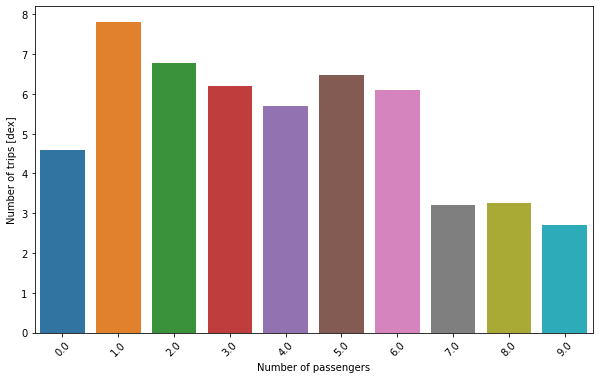

0.2998209450001923


In [45]:
start = timer()

num_passengers = df.passenger_count.value_counts(progress=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=num_passengers.index, y=np.log10(num_passengers.values))
plt.xlabel('Number of passengers')
plt.ylabel('Number of trips [dex]')
plt.xticks(rotation='45')
plt.show()

end = timer()

time = end - start
performance_dict ['vaex'][0] = time
print(time)

### Query-02:  Filter out the trips longer than 100 miles and trips that claim more than 10 people.

In [47]:
start = timer()

df_filtered = df[(df.passenger_count>0) & (df.passenger_count<10) & (df.trip_distance > 0) & (df.trip_distance < 100)]

# end_time = time.time()

end = timer()
time = end - start
performance_dict ['vaex'][1] = time
print(time)

0.04640492999988055


### Query-03: On the filtered data produce a heat map by pick up location color coded by average fare amount.

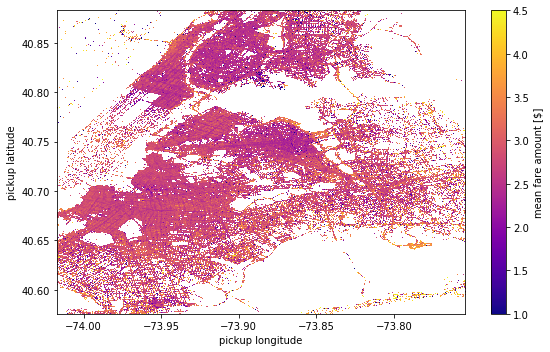

2.052725763000126


In [48]:
start = timer()

plt.figure(figsize=(15, 5))

plt.subplot(121)
df_filtered.plot('pickup_longitude', 'pickup_latitude', what='mean(fare_amount)',
                 colormap='plasma', f='log1p', shape=512, colorbar=True, 
                 colorbar_label='mean fare amount [$]', vmin=1, vmax=4.5)

plt.xlabel('pickup longitude')
plt.ylabel('pickup latitude')

plt.tight_layout()
plt.show()

end = timer()
time = end - start
performance_dict ['vaex'][2] = time
print(time)

### Query-04: Compute the arc distance for the filtered data and plot the distribution number of trips of trip distance and arc distance.

In [49]:
start = timer()

# arc-distance in miles
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# Expression to be pre-compiled with numba, and then executed
df_filtered['arc_distance'] = arc_distance(df_filtered.pickup_longitude, 
                                           df_filtered.pickup_latitude, 
                                           df_filtered.dropoff_longitude, 
                                           df_filtered.dropoff_latitude).jit_numba()

end = timer()
time = end - start
print(time)
performance_dict ['vaex'][3] = time


0.18043347699995138


[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h
[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h
 

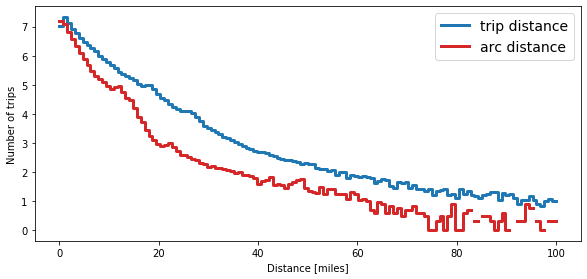

1.098856871999942


In [50]:
start = timer()

plt.figure(figsize=(16, 4))

plt.subplot(121)
df_filtered.plot1d('trip_distance', shape=128, limits=[0, 100], lw=3, f='log10', color='C0', 
                   label='trip distance', progress=True)
df_filtered.plot1d('arc_distance', shape=128, limits=[0, 100], lw=3, f='log10', color='C3', 
                   label='arc distance', progress=True)
plt.legend(fontsize=14)
plt.xlabel('Distance [miles]')
plt.ylabel('Number of trips')

plt.show()

end = timer()
time = end - start
performance_dict ['vaex'][3] = performance_dict ['vaex'][3]+ time
print(time)


## PANDAS

In [51]:
pandas_df = df.to_pandas_df()

In [52]:
pandas_df

,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,pickup_latitude,pickup_longitude,trip_distance
0,0.0,0.0,21.25,1.0,0.0,0.0,0.00
1,0.0,0.0,74.50,2.0,0.0,0.0,0.00
2,0.0,0.0,1.00,1.0,0.0,0.0,0.00
3,0.0,0.0,3.25,1.0,0.0,0.0,0.00
4,0.0,0.0,8.50,1.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...
77837621,NaN,NaN,48.85,NaN,NaN,NaN,10.02
77837622,NaN,NaN,23.31,NaN,NaN,NaN,2.27
77837623,NaN,NaN,27.27,NaN,NaN,NaN,9.35
77837624,NaN,NaN,35.95,NaN,NaN,NaN,-7.16


### Query-01:Plot the number of unique trips with certain number of passengers in the entire green taxi data. (Green taxis can not operate in parts of NYC.)

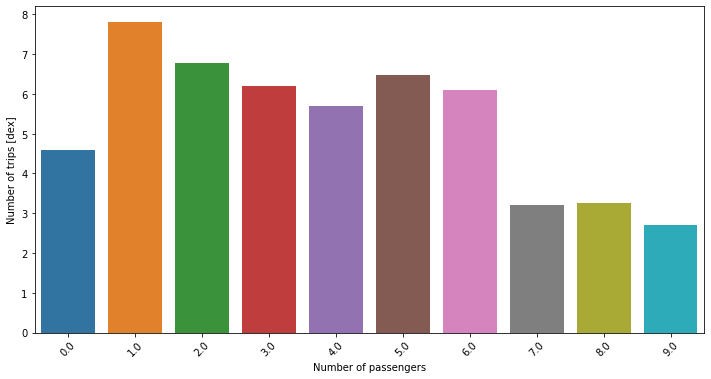

0.9585318309996183


In [53]:
start = timer()

num_passengers = pandas_df.passenger_count.value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=num_passengers.index, y=np.log10(num_passengers.values))
plt.xlabel('Number of passengers')
plt.ylabel('Number of trips [dex]')
plt.xticks(rotation='45')
plt.show()

end = timer()

time = end - start
performance_dict ['pandas'][0] = time
print(time)

### Query-02:  Filter out the trips longer than 100 miles and trips that claim more than 10 people.

In [54]:
start = timer()

pandas_df_filtered = pandas_df[(pandas_df.passenger_count>0) & (pandas_df.passenger_count<10) & (pandas_df.trip_distance > 0) & (pandas_df.trip_distance < 100)]

# end_time = time.time()

end = timer()
time = end - start
performance_dict ['pandas'][1] = time
print(end - start)

9.184652875999745


In [55]:
pandas_df_filtered

,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,pickup_latitude,pickup_longitude,trip_distance
27,0.000000,0.000000,7.5,3.0,0.000000,0.000000,26.47
166,40.758209,-73.937485,3.5,1.0,40.758392,-73.937485,0.01
245,40.840988,-73.882095,14.0,5.0,40.806896,-73.879478,3.03
274,40.719810,-74.001541,49.5,1.0,40.859505,-73.887299,16.87
281,40.869423,-73.904640,11.0,5.0,40.860287,-73.920647,1.84
...,...,...,...,...,...,...,...
77746896,NaN,NaN,15.5,1.0,NaN,NaN,3.77
77746897,NaN,NaN,9.5,1.0,NaN,NaN,2.24
77746898,NaN,NaN,18.0,1.0,NaN,NaN,4.19
77746899,NaN,NaN,27.5,1.0,NaN,NaN,8.27


### Query-03: On the filtered data produce a heat map by pick up location color coded by average fare amount.

122.72604812199961


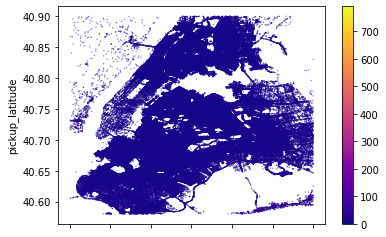

In [56]:
start = timer()

long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90


pandas_df_filtered = pandas_df_filtered[(pandas_df_filtered.pickup_longitude > long_min)  & (pandas_df_filtered.pickup_longitude < long_max) & \
                 (pandas_df_filtered.pickup_latitude > lat_min)    & (pandas_df_filtered.pickup_latitude < lat_max) & \
                 (pandas_df_filtered.dropoff_longitude > long_min) & (pandas_df_filtered.dropoff_longitude < long_max) & \
                 (pandas_df_filtered.dropoff_latitude > lat_min)   & (pandas_df_filtered.dropoff_latitude < lat_max)]


pandas_heatmap = pandas_df_filtered.plot.hexbin(x='pickup_longitude',
                    y='pickup_latitude',
                    C='fare_amount',
                    gridsize=1000,
                    cmap="plasma")

end = timer()
time = end - start
performance_dict ['pandas'][2] = time
print(time)

### Query-04: Compute the arc distance for the filtered data and plot the distribution number of trips of trip distance and arc distance.

In [57]:
start = timer()

# arc-distance in miles
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# Expression to be pre-compiled with numba, and then executed
pandas_df_filtered['arc_distance'] = arc_distance(pandas_df_filtered.pickup_longitude, 
                                           pandas_df_filtered.pickup_latitude, 
                                           pandas_df_filtered.dropoff_longitude, 
                                           pandas_df_filtered.dropoff_latitude)

end = timer()
time = end - start
print(time)
performance_dict['pandas'][3] = time

9.969276530000116


40.20105696599967


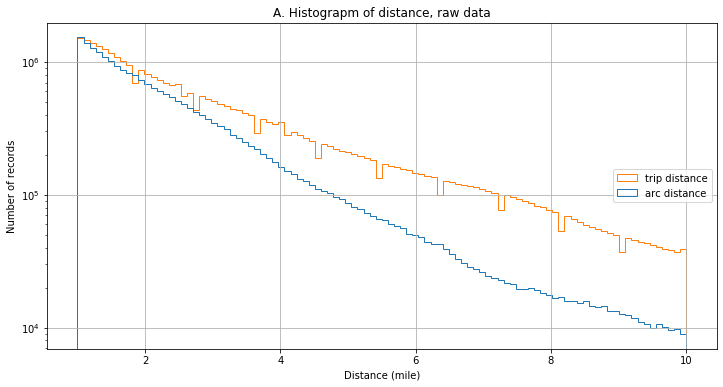

In [58]:
start = timer()

fig, axis = plt.subplots(1,1)
fig.set_size_inches(12, 6)
fig.subplots_adjust(wspace=.5)

y1 = pandas_df_filtered['arc_distance']
y2 = pandas_df_filtered['trip_distance']
axis.hist([y1,y2], bins = 100, histtype='step', range = [1,10], label=['arc distance', 'trip distance'])
axis.set_title('A. Histograpm of distance, raw data')
axis.set_xlabel('Distance (mile)')
axis.set_ylabel('Number of records')
axis.set_yscale('log')
axis.grid(True)
axis.legend(loc='right')

end = timer()
time = end - start
print(time)
performance_dict['pandas'][3]= performance_dict['pandas'][3] + time

## DASK

In [59]:
dask_df = dd.from_pandas(pandas_df, npartitions=3)

### Query-01:Plot the number of unique trips with certain number of passengers in the entire green taxi data. (Green taxis can not operate in parts of NYC.)

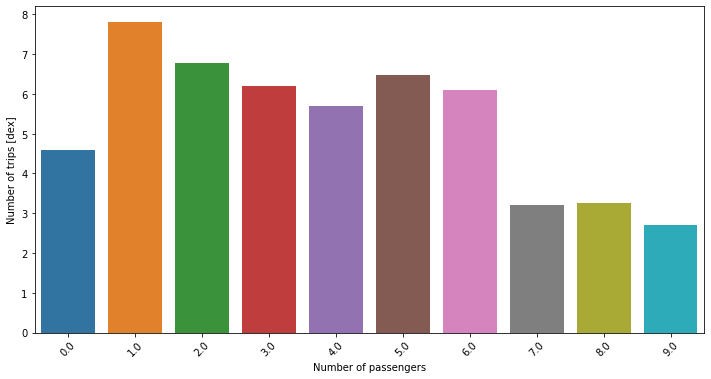

0.921005681999759


In [60]:
start = timer()

num_passengers = dask_df.passenger_count.value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=num_passengers.index.compute(), y=np.log10(num_passengers.values).compute())
plt.xlabel('Number of passengers')
plt.ylabel('Number of trips [dex]')
plt.xticks(rotation='45')
plt.show()

end = timer()

time = end - start
performance_dict ['dask'][0] = time
print(time)

### Query-02:  Filter out the trips longer than 100 miles and trips that claim more than 10 people.

In [62]:
start = timer()

dask_df_filtered = dask_df[(dask_df.passenger_count>0) & (dask_df.passenger_count<10) & (dask_df.trip_distance > 0) & (dask_df.trip_distance < 100)]

# end_time = time.time()

end = timer()
time = end - start
performance_dict ['dask'][1] = time
print(time)

0.005062738000106037


### Query-03: On the filtered data produce a heat map by pick up location color coded by average fare amount.

In [63]:
dask_df_filtered = dask_df_filtered.compute()

107.81867402599983


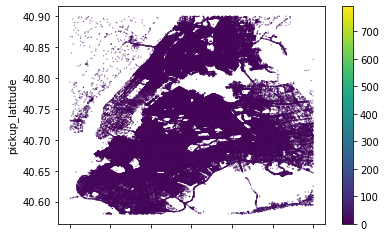

In [64]:
start = timer()

long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90


dask_df_filtered = dask_df_filtered[(dask_df_filtered.pickup_longitude > long_min)  & (dask_df_filtered.pickup_longitude < long_max) & \
                 (dask_df_filtered.pickup_latitude > lat_min)    & (dask_df_filtered.pickup_latitude < lat_max) & \
                 (dask_df_filtered.dropoff_longitude > long_min) & (dask_df_filtered.dropoff_longitude < long_max) & \
                 (dask_df_filtered.dropoff_latitude > lat_min)   & (dask_df_filtered.dropoff_latitude < lat_max)]


dask_df_filtered.plot.hexbin(x='pickup_longitude',
                    y='pickup_latitude',
                    C='fare_amount',
                    reduce_C_function = np.mean,
                    gridsize=1000,
                    cmap="viridis")

end = timer()
time = end - start
performance_dict ['dask'][2] = time
print(time)

### Query-04: Compute the arc distance for the filtered data and plot the distribution number of trips of trip distance and arc distance.

In [65]:
start = timer()

# arc-distance in miles
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# Expression to be pre-compiled with numba, and then executed
dask_df_filtered['arc_distance'] = arc_distance(dask_df_filtered.pickup_longitude, 
                                           dask_df_filtered.pickup_latitude, 
                                           dask_df_filtered.dropoff_longitude, 
                                           dask_df_filtered.dropoff_latitude)

end = timer()
time = end - start
performance_dict['dask'][3] = time

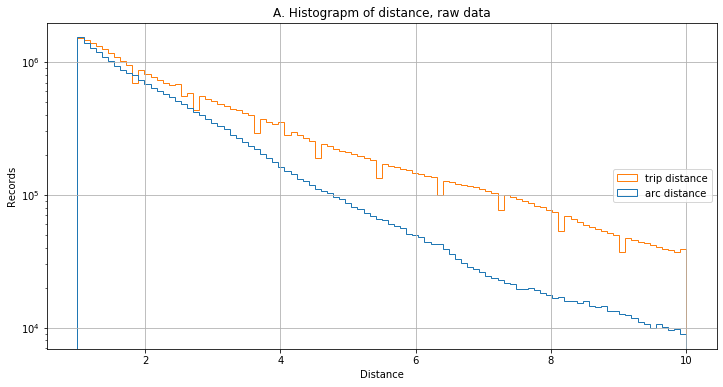

In [67]:
start = timer()

fig, axis = plt.subplots(1,1)
fig.set_size_inches(12, 6)
fig.subplots_adjust(wspace=.5)

y1 = dask_df_filtered['arc_distance']
y2 = dask_df_filtered['trip_distance']
axis.hist([y1,y2], bins = 100, histtype='step', range = [1,10], label=['arc distance', 'trip distance'])
axis.set_title('A. Histograpm of distance, raw data')
axis.set_xlabel('Distance')
axis.set_ylabel('Records')
axis.set_yscale('log')
axis.grid(True)
axis.legend(loc='right')

end = timer()
time = end - start
performance_dict['dask'][3]= performance_dict['dask'][3] + time

## REPORT

Text(0, 0.5, 'Time (in seconds)')

<Figure size 432x288 with 0 Axes>

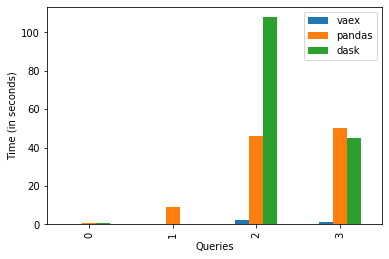

In [68]:
performance = pd.DataFrame.from_dict(performance_dict)
plt.figure()
performance_plot = performance.plot(kind='bar')
performance_plot.set_xlabel('Queries')
performance_plot.set_ylabel('Time (in seconds)')

##### VAEX

* Performance: works with huge tabular data, processes rows/second
* Lazy / Virtual columns: compute on the fly, without wasting ram
* Memory efficient no memory copies when doing filtering/selections/subsets.
* Visualization: directly supported, a one-liner is often enough.

#### PANDAS

* Pandas does not persist data.
* Pandas have a difficulty in dealing with large datasets. If our input file is humongous, pandas wont cut it because it overfits the RAM





#### DASK

* Wherever Pandas lacked speed, that would carry on to Dask DataFrame as well.
* Dask has long training and processing times